In [1]:
from pathlib import Path

DATASET_PATH = Path("../dataset/")
TRAIN_DATA_PATH = DATASET_PATH / "train.csv"
TEST_DATA_PATH = DATASET_PATH / "test.csv"
SUBMIT_DATA_PATH = DATASET_PATH / "sample_submit.csv"

In [2]:
import polars as pl

In [3]:
train_df = pl.scan_csv(TRAIN_DATA_PATH)
test_df = pl.scan_csv(TEST_DATA_PATH).with_columns(pl.lit(99).cast(pl.Int64).alias("blueWins"))
all_df = pl.concat([train_df, test_df]).collect()

In [4]:
from itertools import combinations
from typing import List, Callable
import polars.selectors as cs


def apply_combinations(
    df: pl.DataFrame,
    target_expr: pl.Expr,
    combination_functions: tuple[str, Callable[[List[pl.Expr]], pl.Expr]],
    combination_size: int = 2,
) -> List[pl.Expr]:
    # 結果として返すExprのリスト
    exprs = []

    target_cols = df.select(target_expr).columns

    # 組み合わせを生成し、指定された関数を適用
    for cols in combinations(target_cols, combination_size):
        for combination_function in combination_functions:
            # 組み合わせに対する処理を適用
            combined_expr = combination_function[1]([pl.col(col) for col in cols])
            # 新しいカラム名を生成
            new_column_name = "_".join(cols) + "__" + combination_function[0]
            # Exprリストに追加
            exprs.append(combined_expr.alias(new_column_name))

    return exprs


all_df = (
    all_df.lazy()
    .with_columns(
        (pl.col("blueEliteMonsters") - pl.col("blueDragons")).alias("blueHerald"),
        (pl.col("blueKills") / pl.col("blueDeaths")).alias("blueK/D"),
    )
    .collect()
)


all_df = (
    all_df.lazy()
    .with_columns(
        pl.when(pl.all().is_infinite()).then(9999).otherwise(pl.all()).name.keep()
    )
    .with_columns(
        *apply_combinations(
            all_df,
            pl.exclude(["blueWins", "gameId"]),
            [("multiply", lambda x: x[0] * x[1]), ("sum", lambda x: x[0] + x[1])],
        ),
        *apply_combinations(
            all_df,
            pl.exclude(["blueWins", "gameId"]),
            [
                ("multiply", lambda x: x[0] * x[1] * x[2]),
                ("sum", lambda x: x[0] + x[1] + x[2]),
            ],
            combination_size=3,
        )
    )
    .collect()
)

In [5]:
all_df.describe()

describe,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins,blueHerald,blueK/D,blueFirstBlood_blueKills__multiply,blueFirstBlood_blueKills__sum,blueFirstBlood_blueDeaths__multiply,blueFirstBlood_blueDeaths__sum,blueFirstBlood_blueAssists__multiply,blueFirstBlood_blueAssists__sum,blueFirstBlood_blueEliteMonsters__multiply,blueFirstBlood_blueEliteMonsters__sum,blueFirstBlood_blueDragons__multiply,blueFirstBlood_blueDragons__sum,blueFirstBlood_blueTotalGold__multiply,blueFirstBlood_blueTotalGold__sum,blueFirstBlood_blueTotalExperience__multiply,blueFirstBlood_blueTotalExperience__sum,blueFirstBlood_blueHerald__multiply,blueFirstBlood_blueHerald__sum,blueFirstBlood_blueK/D__multiply,blueFirstBlood_blueK/D__sum,blueKills_blueDeaths__multiply,blueKills_blueDeaths__sum,blueKills_blueAssists__multiply,blueKills_blueAssists__sum,blueKills_blueEliteMonsters__multiply,blueKills_blueEliteMonsters__sum,…,blueEliteMonsters_blueDragons_blueTotalExperience__sum,blueEliteMonsters_blueDragons_blueHerald__multiply,blueEliteMonsters_blueDragons_blueHerald__sum,blueEliteMonsters_blueDragons_blueK/D__multiply,blueEliteMonsters_blueDragons_blueK/D__sum,blueEliteMonsters_blueTotalGold_blueTotalExperience__multiply,blueEliteMonsters_blueTotalGold_blueTotalExperience__sum,blueEliteMonsters_blueTotalGold_blueHerald__multiply,blueEliteMonsters_blueTotalGold_blueHerald__sum,blueEliteMonsters_blueTotalGold_blueK/D__multiply,blueEliteMonsters_blueTotalGold_blueK/D__sum,blueEliteMonsters_blueTotalExperience_blueHerald__multiply,blueEliteMonsters_blueTotalExperience_blueHerald__sum,blueEliteMonsters_blueTotalExperience_blueK/D__multiply,blueEliteMonsters_blueTotalExperience_blueK/D__sum,blueEliteMonsters_blueHerald_blueK/D__multiply,blueEliteMonsters_blueHerald_blueK/D__sum,blueDragons_blueTotalGold_blueTotalExperience__multiply,blueDragons_blueTotalGold_blueTotalExperience__sum,blueDragons_blueTotalGold_blueHerald__multiply,blueDragons_blueTotalGold_blueHerald__sum,blueDragons_blueTotalGold_blueK/D__multiply,blueDragons_blueTotalGold_blueK/D__sum,blueDragons_blueTotalExperience_blueHerald__multiply,blueDragons_blueTotalExperience_blueHerald__sum,blueDragons_blueTotalExperience_blueK/D__multiply,blueDragons_blueTotalExperience_blueK/D__sum,blueDragons_blueHerald_blueK/D__multiply,blueDragons_blueHerald_blueK/D__sum,blueTotalGold_blueTotalExperience_blueHerald__multiply,blueTotalGold_blueTotalExperience_blueHerald__sum,blueTotalGold_blueTotalExperience_blueK/D__multiply,blueTotalGold_blueTotalExperience_blueK/D__sum,blueTotalGold_blueHerald_blueK/D__multiply,blueTotalGold_blueHerald_blueK/D__sum,blueTotalExperience_blueHerald_blueK/D__multiply,blueTotalExperience_blueHerald_blueK/D__sum
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,…,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",499

In [6]:
target_col = pl.col("blueWins")
train_df = all_df.filter(target_col != 99)
test_df = all_df.filter(target_col == 99)

In [7]:
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()

In [8]:
exp.setup(
    data=train_df.to_pandas(),
    target="blueWins",
    ignore_features=["gameId"],
    categorical_features=[
        "blueFirstBlood",
        "blueEliteMonsters",
        "blueDragons",
        "blueHerald",
    ],
    session_id=123,
    fold=10,
    fold_shuffle=True,
    verbose=True,
    use_gpu=True,
    # polynomial_features=True,
    # polynomial_degree=3,
    transformation=True,
    transformation_method="yeo-johnson",
    normalize=True,
    normalize_method="zscore",
    feature_selection=True,
    n_features_to_select=0.5,
    low_variance_threshold=0.1,
)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000

,Description,Value
0,Session id,123
1,Target,blueWins
2,Target type,Binary
3,Original data shape,"(8000, 342)"
4,Transformed data shape,"(8000, 171)"
5,Transformed train set shape,"(5600, 171)"
6,Transformed test set shape,"(2400, 171)"
7,Ignore features,1
8,Ordinal features,2
9,Numeric features,336


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000

In [9]:
best = exp.compare_models(sort="Accuracy", n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7736,0.8629,0.7756,0.7668,0.7710,0.5471,0.5475,21.3730
gbc,Gradient Boosting Classifier,0.7721,0.8609,0.7774,0.7639,0.7703,0.5443,0.5448,6.2450
lightgbm,Light Gradient Boosting Machine,0.7688,0.8531,0.7658,0.7646,0.7650,0.5374,0.5376,2.6280
ada,Ada Boost Classifier,0.7668,0.8506,0.7669,0.7612,0.7636,0.5335,0.5341,2.5120
lda,Linear Discriminant Analysis,0.7541,0.8235,0.7901,0.7316,0.7596,0.5087,0.5106,1.4020
xgboost,Extreme Gradient Boosting,0.7516,0.8370,0.7524,0.7453,0.7485,0.5031,0.5036,1.6950
rf,Random Forest Classifier,0.7514,0.8356,0.7535,0.7446,0.7486,0.5028,0.5034,1.6670
et,Extra Trees Classifier,0.7475,0.8074,0.7466,0.7420,0.7439,0.4949,0.4954,1.6110
knn,K Neighbors Classifier,0.7309,0.7896,0.7208,0.7290,0.7247,0.4615,0.4618,1.3800
ridge,Ridge Classifier,0.7248,0.0000,0.7357,0.7137,0.7244,0.4498,0.4502,1.3820


In [10]:
# tuned_model = exp.tune_model(
#     best, choose_better=True, optimize="Accuracy", search_library="optuna"
# )

In [11]:
tuned_models = [
    exp.tune_model(
        model, choose_better=True, optimize="Accuracy", search_library="optuna"
    )
    for model in best
]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7964,0.8702,0.8116,0.7832,0.7972,0.5930,0.5934
1,0.7500,0.8311,0.7971,0.7237,0.7586,0.5006,0.5031
2,0.7982,0.8778,0.8297,0.7763,0.8021,0.5967,0.5981
3,0.7732,0.8707,0.7826,0.7633,0.7728,0.5465,0.5467
4,0.7786,0.8703,0.8364,0.7443,0.7877,0.5580,0.5621
5,0.7554,0.8595,0.7964,0.7300,0.7617,0.5113,0.5134
6,0.7446,0.8407,0.7382,0.7409,0.7395,0.4891,0.4891
7,0.7607,0.8386,0.8109,0.7311,0.7690,0.5222,0.5252
8,0.7804,0.8501,0.8218,0.7533,0.7861,0.5613,0.5635


[I 2024-01-20 01:42:41,973] Searching the best hyperparameters using 5600 samples...


[LightGBM] [Info] Number of positive: 2478, number of negative: 2562
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30345
[LightGBM] [Info] Number of data points in the train set: 5040, number of used features: 340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491667 -> initscore=-0.033336
[LightGBM] [Info] Start training from score -0.033336
[LightGBM] [Info] Number of positive: 2478, number of negative: 2562
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30422
[LightGBM] [Info] Number of data points in the train set: 5040, number of used features: 340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491667 -> initscore=-0.033336
[LightGBM] [Info] Start training from score -0.033336
[LightGBM] [In

[I 2024-01-20 01:46:37,364] Finished hyperparameter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7750,0.8699,0.6848,0.8289,0.7500,0.5488,0.5571
1,0.7214,0.8243,0.6522,0.7500,0.6977,0.4417,0.4454
2,0.7875,0.8755,0.6848,0.8552,0.7606,0.5737,0.5852
3,0.7804,0.8723,0.6993,0.8283,0.7583,0.5597,0.5664
4,0.7911,0.8735,0.7418,0.8160,0.7771,0.5813,0.5837
5,0.7821,0.8635,0.7127,0.8201,0.7626,0.5631,0.5679
6,0.7482,0.8462,0.6436,0.8045,0.7152,0.4945,0.5044
7,0.7661,0.8475,0.6873,0.8077,0.7426,0.5308,0.5366
8,0.7661,0.8599,0.7273,0.7812,0.7533,0.5314,0.5327


[I 2024-01-20 01:51:09,236] Searching the best hyperparameters using 5600 samples...


[LightGBM] [Info] Number of positive: 2478, number of negative: 2562
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30345
[LightGBM] [Info] Number of data points in the train set: 5040, number of used features: 340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491667 -> initscore=-0.033336
[LightGBM] [Info] Start training from score -0.033336
[LightGBM] [Info] Number of positive: 2478, number of negative: 2562
[LightGBM] [Info] Number of positive: 2478, number of negative: 2562
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30345
[LightGBM] [Info] Number of data points in the train set: 5040, number of used features: 340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491667 -> initscore=-0.033336

[I 2024-01-20 01:59:37,302] Finished hyperparameter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7929,0.8740,0.7935,0.7878,0.7906,0.5857,0.5857
1,0.7446,0.8372,0.7572,0.7333,0.7451,0.4894,0.4897
2,0.8018,0.8776,0.7971,0.8000,0.7985,0.6035,0.6035
3,0.7982,0.8735,0.7971,0.7942,0.7957,0.5964,0.5964
4,0.7875,0.8741,0.8218,0.7635,0.7916,0.5754,0.5771
5,0.7714,0.8676,0.7855,0.7579,0.7714,0.5430,0.5433
6,0.7536,0.8492,0.7164,0.7665,0.7406,0.5064,0.5075
7,0.7679,0.8445,0.7782,0.7562,0.7670,0.5358,0.5360
8,0.7696,0.8556,0.7927,0.7517,0.7717,0.5396,0.5404


[I 2024-01-20 02:02:55,145] Searching the best hyperparameters using 5600 samples...


[LightGBM] [Info] Number of positive: 2478, number of negative: 2562
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30345
[LightGBM] [Info] Number of data points in the train set: 5040, number of used features: 340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491667 -> initscore=-0.033336
[LightGBM] [Info] Start training from score -0.033336
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9884585190307693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9884585190307693
[LightGBM] [Warning] bagging_fraction is set=0.810897843150918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.810897843150918
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning

[I 2024-01-20 02:09:07,224] Finished hyperparameter search!


[LightGBM] [Warning] No further splits with positive gain, training stopped with 38 leaves.
[LightGBM] [Warning] No further splits with positive gain, training stopped with 42 leaves.
[LightGBM] [Warning] No further splits with positive gain, training stopped with 36 leaves.
[LightGBM] [Warning] No further splits with positive gain, training stopped with 36 leaves.
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4906764714088482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4906764714088482
[LightGBM] [Warning] bagging_fraction is set=0.6393257756356939, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6393257756356939


In [12]:
blend_model = exp.blend_models(
    tuned_models, method="soft", choose_better=False, optimize="Accuracy"
)

tuned_model = exp.tune_model(
    blend_model, choose_better=True, optimize="Accuracy", search_library="optuna"
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7893,0.8785,0.7862,0.7862,0.7862,0.5785,0.5785
1,0.7411,0.8396,0.7391,0.7365,0.7378,0.4821,0.4821
2,0.7893,0.8819,0.7717,0.7948,0.7831,0.5783,0.5785
3,0.7964,0.8795,0.7971,0.7914,0.7942,0.5928,0.5928
4,0.7964,0.8825,0.8291,0.7729,0.8000,0.5932,0.5948
5,0.7714,0.8706,0.7782,0.7616,0.7698,0.5429,0.5430
6,0.7536,0.8554,0.7236,0.7625,0.7425,0.5065,0.5072
7,0.7768,0.8517,0.7818,0.7679,0.7748,0.5536,0.5537
8,0.7732,0.8634,0.7964,0.7552,0.7752,0.5467,0.5475


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7929,0.8791,0.7935,0.7878,0.7906,0.5857,0.5857
1,0.7411,0.8405,0.7391,0.7365,0.7378,0.4821,0.4821
2,0.7929,0.8805,0.7899,0.7899,0.7899,0.5856,0.5856
3,0.7964,0.8784,0.7935,0.7935,0.7935,0.5928,0.5928
4,0.7929,0.8803,0.8218,0.7713,0.7958,0.5861,0.5873
5,0.7679,0.8708,0.7818,0.7544,0.7679,0.5359,0.5362
6,0.7607,0.8553,0.7345,0.7681,0.7509,0.5209,0.5214
7,0.7768,0.8517,0.7855,0.7660,0.7756,0.5536,0.5538
8,0.7732,0.8611,0.8000,0.7534,0.7760,0.5468,0.5478


[I 2024-01-20 02:15:29,754] Searching the best hyperparameters using 5600 samples...


[LightGBM] [Info] Number of positive: 2478, number of negative: 2562
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30345
[LightGBM] [Info] Number of data points in the train set: 5040, number of used features: 340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491667 -> initscore=-0.033336
[LightGBM] [Info] Start training from score -0.033336
[LightGBM] [Info] Number of positive: 2478, number of negative: 2562
[LightGBM] [Info] Number of positive: 2478, number of negative: 2562
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30345
[LightGBM] [Info] Number of data points in the train set: 5040, number of used features: 340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491667 -> initscore=-0.033336

[W 2024-01-20 02:16:05,367] Trial 0 failed with parameters: {'actual_estimator__weight_0': 0.011984687853320608, 'actual_estimator__weight_1': 0.3721907267695001, 'actual_estimator__weight_2': 0.44676767761192415} because of the following error: CatBoostError('/src/catboost/catboost/cuda/cuda_lib/devices_provider.h:190: Error: device already requested 0').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/usr/local/lib/python3.10/dist-packages/optuna/integration/sklearn.py", line 220, in __call__
    scores = cross_validate(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 266, in cross_validate
    results = parallel(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/usr/local/lib/python3.10/dist-packages/jobli

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6144385400099057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6144385400099057
[LightGBM] [Warning] bagging_fraction is set=0.42615487827942433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42615487827942433
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6144385400099057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6144385400099057
[LightGBM] [Warning] bagging_fraction is set=0.42615487827942433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42615487827942433
[LightGBM] [Info] Number of positive: 2478, number of negative: 2562
[LightGBM] [Info] Total Bins

[I 2024-01-20 02:21:10,975] Finished hyperparameter search!


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6144385400099057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6144385400099057
[LightGBM] [Warning] bagging_fraction is set=0.42615487827942433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42615487827942433


In [13]:
exp.predict_model(tuned_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7883,0.8706,0.7941,0.7795,0.7867,0.5767,0.5768


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6144385400099057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6144385400099057
[LightGBM] [Warning] bagging_fraction is set=0.42615487827942433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42615487827942433
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6144385400099057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6144385400099057
[LightGBM] [Warning] bagging_fraction is set=0.42615487827942433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42615487827942433


,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueHerald,blueK/D,...,blueTotalGold_blueTotalExperience_blueHerald__sum,blueTotalGold_blueTotalExperience_blueK/D__multiply,blueTotalGold_blueTotalExperience_blueK/D__sum,blueTotalGold_blueHerald_blueK/D__multiply,blueTotalGold_blueHerald_blueK/D__sum,blueTotalExperience_blueHerald_blueK/D__multiply,blueTotalExperience_blueHerald_blueK/D__sum,blueWins,prediction_label,prediction_score
4192,0,0,8,0,0,0,17409,17256,0,0.000000,...,34665,0.0,34665.000000,0.000000,17409.000000,0.000000,17256.000000,0,0,0.8932
933,0,6,6,8,0,0,20619,17256,0,1.000000,...,37875,355801472.0,37876.000000,0.000000,20620.000000,0.000000,17257.000000,0,0,0.7283
353,0,4,4,3,0,0,18117,18201,0,1.000000,...,36318,329747520.0,36319.000000,0.000000,18118.000000,0.000000,18202.000000,1,1,0.6618
3469,0,7,6,8,0,0,18117,18491,0,1.166667,...,36608,390835008.0,36609.167969,0.000000,18118.166016,0.000000,18492.166016,1,1,0.6734
2755,0,5,6,6,0,0,17409,17256,0,0.833333,...,34665,250341424.0,34665.832031,0.000000,17409.833984,0.000000,17256.833984,0,0,0.8766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,0,5,6,5,1,1,16961,18472,0,0.833333,...,35433,261086320.0,35433.832031,0.000000,16961.833984,0.000000,18472.833984,0,1,0.5343
6017,0,6,10,4,1,0,20619,17256,1,0.600000,...,37876,213480880.0,37875.601562,12371.400391,20620.599609,10353.599609,17257.599609,0,0,0.8200
4257,0,4,12,2,0,0,17409,17256,0,0.333333,...,34665,100136568.0,34665.332031,0.000000,17409.333984,0.000000,17256.333984,0,0,0.8982
6028,1,9,5,11,1,1,19558,18201,0,1.800000,...,37759,640755264.0,37760.800781,0.000000,19559.800781,0.000000,18202.800781,1,1,0.6449


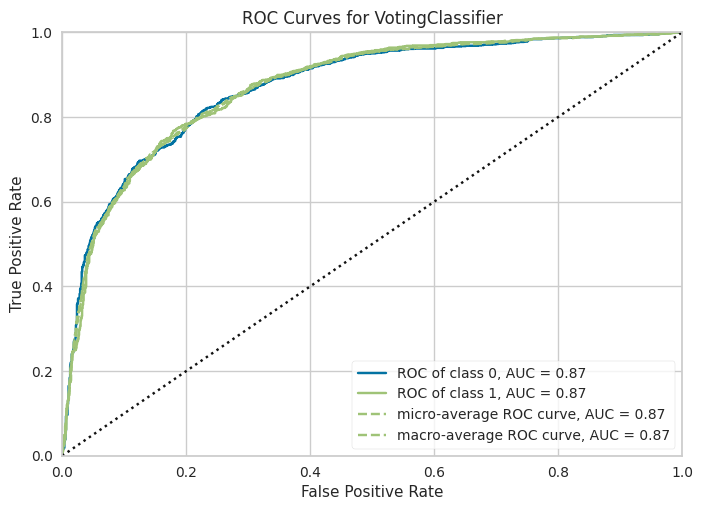

In [14]:
exp.plot_model(tuned_model,plot="auc")

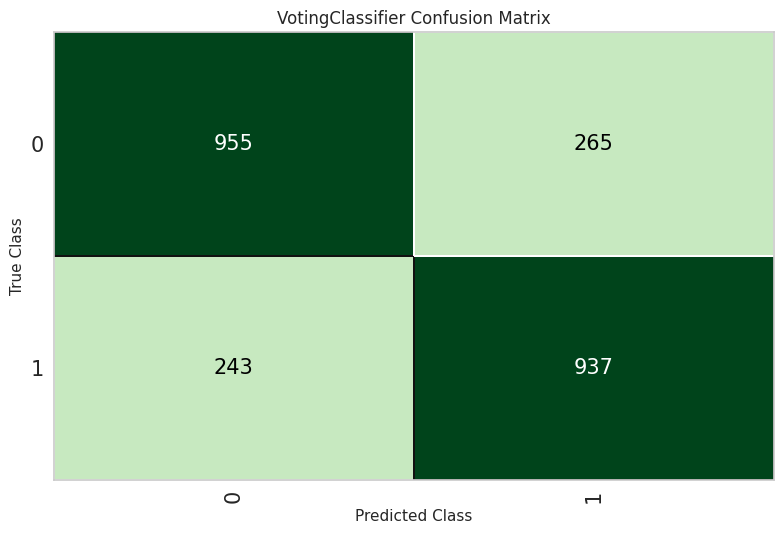

In [15]:
exp.plot_model(tuned_model,plot="confusion_matrix")

In [16]:
exp.evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [17]:
final_model = exp.finalize_model(tuned_model)

In [18]:
unseen_predictions = exp.predict_model(final_model, data=test_df.to_pandas())
unseen_predictions

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6144385400099057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6144385400099057
[LightGBM] [Warning] bagging_fraction is set=0.42615487827942433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42615487827942433
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6144385400099057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6144385400099057
[LightGBM] [Warning] bagging_fraction is set=0.42615487827942433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42615487827942433


,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueHerald,...,blueTotalGold_blueTotalExperience_blueHerald__sum,blueTotalGold_blueTotalExperience_blueK/D__multiply,blueTotalGold_blueTotalExperience_blueK/D__sum,blueTotalGold_blueHerald_blueK/D__multiply,blueTotalGold_blueHerald_blueK/D__sum,blueTotalExperience_blueHerald_blueK/D__multiply,blueTotalExperience_blueHerald_blueK/D__sum,blueWins,prediction_label,prediction_score
0,9,0,7,6,6,0,0,16961,18201,0,...,35162,360158368.0,35163.167969,0.0,16962.166016,0.0,18202.166016,99,1,0.6279
1,15,0,6,6,6,2,1,18513,18021,1,...,36535,333622784.0,36535.000000,18513.0,18515.000000,18021.0,18023.000000,99,1,0.7240
2,18,1,6,4,3,0,0,13475,17256,0,...,30731,348786912.0,30732.500000,0.0,13476.500000,0.0,17257.500000,99,0,0.5737
3,23,0,5,4,7,0,0,17409,17256,0,...,34665,375512128.0,34666.250000,0.0,17410.250000,0.0,17257.250000,99,0,0.8516
4,31,0,10,8,9,0,0,18117,18472,0,...,36589,418321536.0,36590.250000,0.0,18118.250000,0.0,18473.250000,99,1,0.5582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9971,0,6,3,7,0,0,17409,17256,0,...,34665,600819392.0,34667.000000,0.0,17411.000000,0.0,17258.000000,99,0,0.8170
1996,9980,0,4,4,4,0,0,17409,17256,0,...,34665,300409696.0,34666.000000,0.0,17410.000000,0.0,17257.000000,99,0,0.8435
1997,9983,1,6,3,3,1,1,18513,18201,0,...,36714,673910208.0,36716.000000,0.0,18515.000000,0.0,18203.000000,99,1,0.8327
1998,9996,1,10,9,9,1,1,18513,18201,0,...,36714,374394560.0,36715.109375,0.0,18514.111328,0.0,18202.111328,99,1,0.8238


In [19]:
unseen_predictions[["gameId", "prediction_label"]].rename(
    columns={"prediction_label": "blueWins"}
).to_csv("submit.csv", index=False,header=False)

In [20]:
exp.dataset_transformed.describe()

,blueTotalExperience,blueFirstBlood_blueDeaths__sum,blueFirstBlood_blueEliteMonsters__sum,blueFirstBlood_blueTotalGold__multiply,blueFirstBlood_blueK/D__sum,blueKills_blueDeaths__multiply,blueKills_blueAssists__multiply,blueKills_blueEliteMonsters__sum,blueKills_blueDragons__multiply,blueKills_blueTotalGold__multiply,...,blueEliteMonsters_blueHerald_blueK/D__sum,blueDragons_blueTotalGold_blueTotalExperience__multiply,blueDragons_blueTotalGold_blueTotalExperience__sum,blueDragons_blueTotalGold_blueK/D__sum,blueDragons_blueHerald_blueK/D__multiply,blueTotalGold_blueTotalExperience_blueK/D__multiply,blueTotalGold_blueTotalExperience_blueK/D__sum,blueTotalGold_blueHerald_blueK/D__multiply,blueTotalGold_blueHerald_blueK/D__sum,blueWins
count,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,-6.977058e-17,-0.004694,-0.012177,-0.008207,-0.006045,-0.007316,-0.008369,-0.008053,-0.009651,-0.005709,...,-0.006511,-0.009489,-0.011261,-0.001404,-0.022210,0.003615,-0.007851,-0.011377,-0.001403,0.491750
std,4.172485e-15,0.999888,1.000334,1.000390,1.006696,0.997502,0.998284,1.000077,0.997722,0.999252,...,1.004781,0.997285,0.994665,0.997932,1.694442,1.008327,0.999871,1.470511,0.997936,0.499963
min,-8.659740e-15,-3.620003,-1.315191,-1.034695,-2.639839,-2.659355,-2.165779,-2.709159,-0.749444,-3.185450,...,-4.643282,-0.754362,-2.099706,-1.955282,-123.223547,-5.536219,-2.407886,-96.497335,-1.955287,0.000000
25%,-4.218847e-15,-0.510267,-1.315191,-1.034695,-0.756311,-0.720678,-0.688541,-0.517885,-0.749444,-0.646234,...,-0.775975,-0.754362,-0.313623,-0.310326,-0.207209,-0.278582,-0.214130,-0.007106,-0.310332,0.000000
50%,4.996004e-16,-0.090912,0.082201,0.915730,0.185622,-0.069242,-0.073239,-0.156630,-0.749444,0.043899,...,0.068112,-0.754362,-0.076934,0.124588,-0.207209,-0.008165,0.008808,-0.007106,0.124685,0.000000
75%,2.942091e-15,0.665270,1.051065,0.973793,0.668076,0.684809,0.632176,0.528642,1.267385,0.690204,...,0.727057,1.325838,0.737985,0.551267,-0.207209,0.286480,0.699073,-0.007106,0.551137,1.000000
max,9.992007e-15,2.795522,1.816666,1.012323,3.787650,3.964822,2.860920,2.958484,1.545705,2.781127,...,3.545742,1.335529,3.152056,5.585153,6.743696,9.117997,4.818373,24.310802,5.585365,1.000000
